#  CE-40959: Deep Learning

## Homework 5 - 1: VAE

The goal is to VAE!!!!

Good luck

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

---

In [0]:
CUDA = True
BATCH_SIZE = 128
LEARNING_RATE = 0.05

---

In [0]:
# Reproducibility options

np.random.seed(0)
torch.manual_seed(0)

if CUDA:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

---

In [0]:
# MNIST Dataset
original_train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
original_test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=True)

In [0]:
# Define Train loader
train_tensors = original_train_dataset.data.float() / 255
test_tensors = original_test_dataset.data.float() / 255

# Define Datasets
train_dataset = torch.utils.data.TensorDataset(train_tensors, original_train_dataset.targets)
test_dataset = torch.utils.data.TensorDataset(test_tensors, original_test_dataset.targets)

# Define dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

---

In [0]:
class VAE(nn.Module):
    def __init__(self, input_dim, encoder_dims, z_dim, decoder_dims, dropout_rate=0.2):
        super(VAE, self).__init__()
        
        self.input_dim = input_dim
        self.z_dim = z_dim
        
        ########################## TODO ##########################
        # self.input_dropout must be a dropout module with p=dropout_rate
        self.input_dropout = nn.Dropout(p=dropout_rate)
        ######################## END TODO ########################
        
        # Encoder part
        encoder_layers = []
        ########################## TODO ##########################
        # Define encoder layers and add them to `encoder_layers`
        # Use ReLU for activation functions
        encoder_layers.append(nn.Linear(input_dim, encoder_dims[0]))
        encoder_layers.append(nn.ReLU())
        for i in range(len(encoder_dims)-1):
          encoder_layers.append(nn.Linear(encoder_dims[i], encoder_dims[i+1]))
          encoder_layers.append(nn.ReLU())
        ######################## END TODO ########################
        self.encoder = nn.Sequential(*encoder_layers)
        
        encoder_last_dim = ([input_dim] + encoder_dims)[-1]
        
        # mu and log_var
        ########################## TODO ##########################
        # Define mu and log_var layers
        # They do not need any activation function
        self.mu_layer = nn.Linear(encoder_last_dim, z_dim)
        self.log_var_layer = nn.Linear(encoder_last_dim, z_dim)
        ######################## END TODO ########################
        
        # Decoder part
        decoder_layers = []
        ########################## TODO ##########################
        # Define decoder layers and add them to `decoder_layers`
        # Use ReLU for activation functions
        # Last layer does not need any activation function
        decoder_layers.append(nn.Linear(z_dim, decoder_dims[0]))
        decoder_layers.append(nn.ReLU())
        for i in range(len(decoder_dims)-1):
          decoder_layers.append(nn.Linear(decoder_dims[i], decoder_dims[i+1]))
          decoder_layers.append(nn.ReLU())
#         injaro chikar konam???
        decoder_layers.append(nn.Linear(decoder_dims[-1], self.input_dim))
        ######################## END TODO ########################
        self.decoder = nn.Sequential(*decoder_layers)

    @staticmethod
    def _sampling(mu, log_var, bs):
        """
        This function is in charge of reparametrization trick
        """
        ########################## TODO ##########################
        # Generate a random z from N(mu=mu, var=e^log_var)
#         print(log_var)
        z = torch.distributions.multivariate_normal.MultivariateNormal(mu, torch.exp(log_var)).sample((bs,))
#         or torch.distributions.multivariate_normal.MultivariateNormal????????

        ######################## END TODO ########################
        return z

    def forward(self, data):
        x = data.get("X")
        ########################## TODO ##########################
        # Complete the flow
        # x > dropout > encoder > mu, log_var > z > decoder > output
        x = self.input_dropout(x)
        hidden = self.encoder(x)
        mu = self.mu_layer(hidden)
        log_var = self.log_var_layer(hidden)
#         print(log_var.shape)
        eps = self._sampling(torch.zeros(self.z_dim), torch.eye(self.z_dim), mu.shape[0]).cuda()
#         print(eps.device, log_var.device, mu.device)
        z = eps * torch.exp(log_var) + mu
        output = self.decoder(z)
        
        
        
        ######################## END TODO ########################
        return {"X": output, "mu": mu, "log_var": log_var, "z": z}
    
    def loss(self, data, output):
      x = data.get("X")
      recon_x = output.get("X")
      mu = output.get("mu")
      log_var = output.get("log_var")
      ########################## TODO ##########################
      # Calculate MSE and KLD
      mse_loss = nn.MSELoss(reduction='sum')
      MSE = mse_loss(x, recon_x)
      KLD = (-log_var + (torch.pow(torch.exp(log_var), 2) + torch.pow(mu, 2) - 1)/2).sum()
      ######################## END TODO ########################
      return {"final": MSE + KLD, "KLD": KLD, "MSE": MSE}

---

In [0]:
def train(model, data_loader, optimizer, epoch="?", print_every=100, verbose=True):
    """
    This function trains a `model` given a `data_loader` by `optimizer`
    """
    model.train()

    train_loss = 0

    for batch_idx, batch_data in enumerate(data_loader):
        supervised_training = len(batch_data) == 2

        if supervised_training:
            # Labeled data
            data = {"X": batch_data[0],
                    "Y": batch_data[1]}
        else:
            # Unlabeled data
            data = {"X": batch_data[0]}

        # Flatten data
        ########################## TODO ##########################
        # Use `flatten` function from pytorch
        data['X'] = data['X'].flatten(start_dim=1)
        ######################## END TODO ########################

        if CUDA:
            ########################## TODO ##########################
            # Send tensors in data to GPU
            if supervised_training:
              data['X'] = data['X'].cuda()
              data['Y'] = data['Y'].cuda()
            else:
              data['X'] = data['X'].cuda()
            ######################## END TODO ########################


        ########################## TODO ##########################
        # Think about this part
        ######################## END TODO ########################
        optimizer.zero_grad()

        output = model(data)
        loss = model.loss(data, output)
        final_loss = loss["final"]
        train_loss += final_loss.item()

        final_loss.backward()
        optimizer.step()
        ########################## TODO ##########################
        # Thinking ends here
        ######################## END TODO ########################

        if batch_idx % print_every == 0 and verbose:
            print('Train | Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data["X"]), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), final_loss.item() / len(data["X"])))

    train_loss /= len(data_loader.dataset)
    if verbose:
        print('====> Train | Epoch: {} \t | \t Average loss: {:.4f}'.format(epoch, train_loss,))

    return {"final": train_loss}

In [0]:
def test(model, data_loader, verbose=True):
    """
    This function tests a `model` on a `data_loader`
    """
    model.eval()

    test_loss = 0

    labels, y_preds = None, None
    with torch.no_grad():
        for batch_data  in data_loader:
            supervised = len(batch_data) == 2

            if supervised:
                # Labeled data
                data = {"X": batch_data[0],
                        "Y": batch_data[1]}
            else:
                # Unlabeled data
                data = {"X": batch_data[0]}

            #  Flatten data
            ########################## TODO ##########################
            # Use `flatten` function from pytorch
            data['X'] = data['X'].flatten(start_dim=1)
            ######################## END TODO ########################

            if CUDA:
                ########################## TODO ##########################
                # Send tensors in data to GPU
                if supervised:
                  data['X'] = data['X'].cuda()
                  data['Y'] = data['Y'].cuda()
                else:
                  data['X'] = data['X'].cuda()
                ######################## END TODO ########################

            output = model(data)
            loss = model.loss(data, output)
            final_loss = loss["final"]
            test_loss += final_loss.item()

            # Storing y_true and y_pred if learning is supervised
            supervised = supervised and "Y" in output
            if supervised:
                y_pred = np.argmax(output["Y"].detach().cpu().numpy(), axis=1)
                y_true = data["Y"].cpu().numpy()
                if labels is None:
                    labels = y_true
                    y_preds = y_pred
                else:
                    labels = np.concatenate((labels, y_true), axis=None)
                    y_preds = np.concatenate((y_preds, y_pred), axis=None)

    test_loss /= len(data_loader.dataset)

    if supervised:
        accuracy = accuracy_score(labels, y_preds)
        if verbose:
            print('====> Test  | model loss: {:.4f}'.format(test_loss))
            print('            |   accuracy: {:.4f}'.format(100 * accuracy))
            print(classification_report(labels, y_preds))
        return {"final": test_loss, "accuracy": accuracy}
    else:
        if verbose:
            print('====> Test  | model loss: {:.4f}'.format(test_loss))
        return {"final": test_loss}

In [0]:
def run(model, parameters, n_epoch, train_loader, test_loader,
        end_function=lambda model:None):
    """
    This function will optimize `parameters` of `model` for `n_epoch` epochs
    on `train_loader` dataset and validate it on `test_loader`.
    At the end of each epoch, `end_function` will be called on `model`.
    """
    if CUDA:
        model.cuda()

    ########################## TODO ##########################
    # Initialize a new Adam optimizer.
    # Set learning rate to LEARNING_RATE / BATCH_SIZE (why?)
    optimizer = optim.Adam(parameters, lr=LEARNING_RATE / BATCH_SIZE)
    ######################## END TODO ########################

    for epoch in range(1, n_epoch + 1):
        train_loss = train(model, train_loader, optimizer, epoch)
        test_loss = test(model, test_loader)
        end_function(model)

In [0]:
def show(image_batch, rows=1):
    # Set Plot dimensions
    cols = np.ceil(image_batch.shape[0] / rows)
    plt.rcParams['figure.figsize'] = (0.0 + cols, 0.0 + rows) # set default size of plots
    
    for i in range(image_batch.shape[0]):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image_batch[i], cmap="gray", vmin=0, vmax=1)
        plt.axis('off')
    plt.show()
    
# indices = torch.randint(train_loader.dataset.tensors[0].shape[0], (2,))
# img_1 = train_loader.dataset.tensors[0][indices][:1]
# img_2 = train_loader.dataset.tensors[0][indices][1:].flatten(start_dim=1)
# show(np.array(img_1))

---

In [152]:
vae = VAE(784, encoder_dims=[512, 128], z_dim=32, decoder_dims=[128, 512])
print(vae)

# Output might be like:
# VAE(
#   (input_dropout): Dropout(p=0.2)
#   (encoder): Sequential(
#     (0): Linear(in_features=784, out_features=512, bias=True)
#     (1): ReLU()
#     (2): Linear(in_features=512, out_features=128, bias=True)
#     (3): ReLU()
#   )
#   (mu_layer): Linear(in_features=128, out_features=32, bias=True)
#   (log_var_layer): Linear(in_features=128, out_features=32, bias=True)
#   (decoder): Sequential(
#     (0): Linear(in_features=32, out_features=128, bias=True)
#     (1): ReLU()
#     (2): Linear(in_features=128, out_features=512, bias=True)
#     (3): ReLU()
#     (4): Linear(in_features=512, out_features=784, bias=True)
#   )
# )

VAE(
  (input_dropout): Dropout(p=0.2)
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
  )
  (mu_layer): Linear(in_features=128, out_features=32, bias=True)
  (log_var_layer): Linear(in_features=128, out_features=32, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [0]:
def show_vae(vae):
    # Select 10 random inputs
    data_loader = train_loader
    indices = torch.randint(data_loader.dataset.tensors[0].shape[0], (10,))
    input_img = data_loader.dataset.tensors[0][indices]
    print("Inputs:")
    show(input_img.numpy())
    # Calculate reconstructions
    input_img = input_img.flatten(start_dim=1)
    if CUDA:
        input_img = input_img.cuda()
    recons_img = vae({"X": input_img})["X"]
    recons_img = recons_img.detach().cpu().view(-1, 28, 28).numpy()
    print("Reconstructions:")
    show(recons_img)
    # Generate images
    z = torch.randn(10, vae.z_dim)
    if CUDA:
        z = z.cuda()
    generated_img = vae.decoder(z)
    generated_img = generated_img.detach().cpu().view(-1, 28, 28).numpy()
    print("Generated Images:")
    show(generated_img)

Train | Epoch: 1 [0/60000 (0%)]	Loss: 109.972427
Train | Epoch: 1 [12800/60000 (21%)]	Loss: 52.712761
Train | Epoch: 1 [25600/60000 (43%)]	Loss: 53.765636
Train | Epoch: 1 [38400/60000 (64%)]	Loss: 52.895863
Train | Epoch: 1 [51200/60000 (85%)]	Loss: 51.241753
====> Train | Epoch: 1 	 | 	 Average loss: 53.2015
====> Test  | model loss: 50.2698
Inputs:


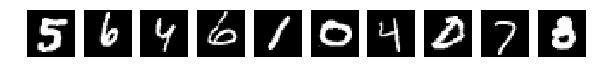

Reconstructions:


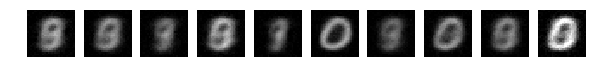

Generated Images:


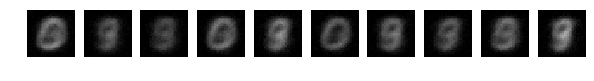

Train | Epoch: 2 [0/60000 (0%)]	Loss: 52.399963
Train | Epoch: 2 [12800/60000 (21%)]	Loss: 47.603867
Train | Epoch: 2 [25600/60000 (43%)]	Loss: 48.876556
Train | Epoch: 2 [38400/60000 (64%)]	Loss: 47.156425
Train | Epoch: 2 [51200/60000 (85%)]	Loss: 42.766762
====> Train | Epoch: 2 	 | 	 Average loss: 47.2391
====> Test  | model loss: 44.1695
Inputs:


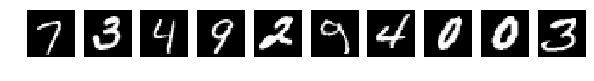

Reconstructions:


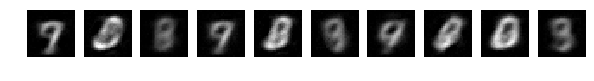

Generated Images:


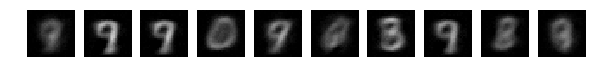

Train | Epoch: 3 [0/60000 (0%)]	Loss: 45.134281
Train | Epoch: 3 [12800/60000 (21%)]	Loss: 42.886673
Train | Epoch: 3 [25600/60000 (43%)]	Loss: 39.980259
Train | Epoch: 3 [38400/60000 (64%)]	Loss: 42.783340
Train | Epoch: 3 [51200/60000 (85%)]	Loss: 44.192322
====> Train | Epoch: 3 	 | 	 Average loss: 42.4760
====> Test  | model loss: 40.3829
Inputs:


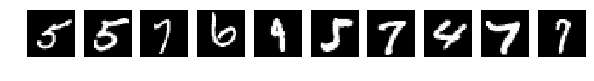

Reconstructions:


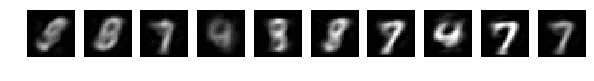

Generated Images:


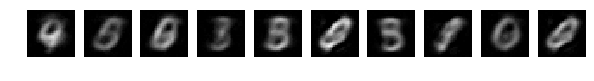

Train | Epoch: 4 [0/60000 (0%)]	Loss: 41.325417
Train | Epoch: 4 [12800/60000 (21%)]	Loss: 40.369339
Train | Epoch: 4 [25600/60000 (43%)]	Loss: 39.589699
Train | Epoch: 4 [38400/60000 (64%)]	Loss: 39.092350
Train | Epoch: 4 [51200/60000 (85%)]	Loss: 39.900097
====> Train | Epoch: 4 	 | 	 Average loss: 39.6273
====> Test  | model loss: 38.0968
Inputs:


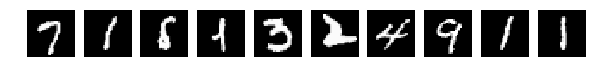

Reconstructions:


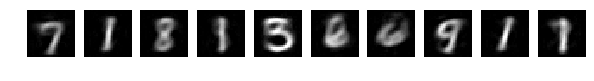

Generated Images:


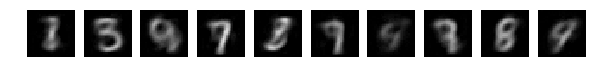

Train | Epoch: 5 [0/60000 (0%)]	Loss: 39.280380
Train | Epoch: 5 [12800/60000 (21%)]	Loss: 39.015781
Train | Epoch: 5 [25600/60000 (43%)]	Loss: 36.343426
Train | Epoch: 5 [38400/60000 (64%)]	Loss: 37.617313
Train | Epoch: 5 [51200/60000 (85%)]	Loss: 38.571609
====> Train | Epoch: 5 	 | 	 Average loss: 37.6574
====> Test  | model loss: 36.5426
Inputs:


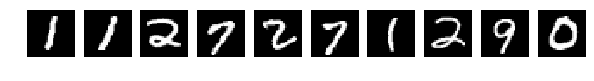

Reconstructions:


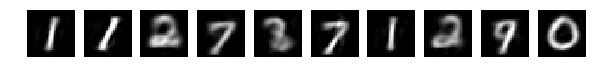

Generated Images:


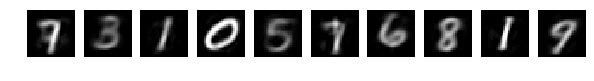

Train | Epoch: 6 [0/60000 (0%)]	Loss: 37.201469
Train | Epoch: 6 [12800/60000 (21%)]	Loss: 37.997166
Train | Epoch: 6 [25600/60000 (43%)]	Loss: 37.878651
Train | Epoch: 6 [38400/60000 (64%)]	Loss: 35.922771
Train | Epoch: 6 [51200/60000 (85%)]	Loss: 35.997196
====> Train | Epoch: 6 	 | 	 Average loss: 36.6531
====> Test  | model loss: 35.8280
Inputs:


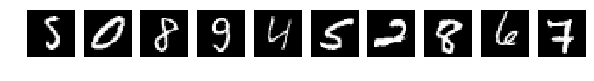

Reconstructions:


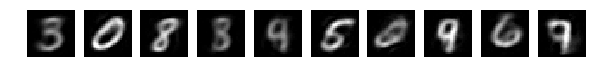

Generated Images:


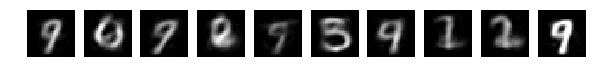

Train | Epoch: 7 [0/60000 (0%)]	Loss: 35.210281
Train | Epoch: 7 [12800/60000 (21%)]	Loss: 34.403042
Train | Epoch: 7 [25600/60000 (43%)]	Loss: 35.018181
Train | Epoch: 7 [38400/60000 (64%)]	Loss: 36.113049
Train | Epoch: 7 [51200/60000 (85%)]	Loss: 33.738304
====> Train | Epoch: 7 	 | 	 Average loss: 35.9768
====> Test  | model loss: 35.2489
Inputs:


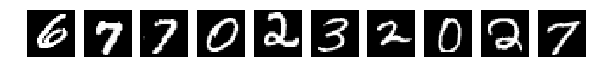

Reconstructions:


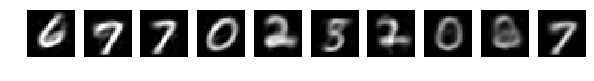

Generated Images:


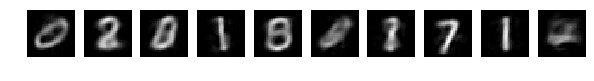

Train | Epoch: 8 [0/60000 (0%)]	Loss: 36.795189
Train | Epoch: 8 [12800/60000 (21%)]	Loss: 36.381081
Train | Epoch: 8 [25600/60000 (43%)]	Loss: 36.502132
Train | Epoch: 8 [38400/60000 (64%)]	Loss: 35.030739
Train | Epoch: 8 [51200/60000 (85%)]	Loss: 35.142464
====> Train | Epoch: 8 	 | 	 Average loss: 35.4878
====> Test  | model loss: 34.8116
Inputs:


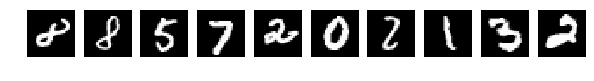

Reconstructions:


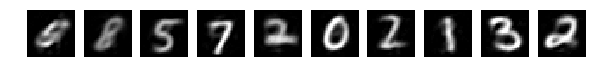

Generated Images:


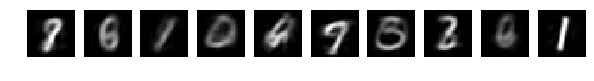

Train | Epoch: 9 [0/60000 (0%)]	Loss: 34.156036
Train | Epoch: 9 [12800/60000 (21%)]	Loss: 35.000381
Train | Epoch: 9 [25600/60000 (43%)]	Loss: 35.530174
Train | Epoch: 9 [38400/60000 (64%)]	Loss: 35.041855
Train | Epoch: 9 [51200/60000 (85%)]	Loss: 33.374390
====> Train | Epoch: 9 	 | 	 Average loss: 35.0917
====> Test  | model loss: 34.4934
Inputs:


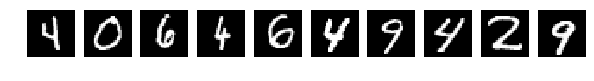

Reconstructions:


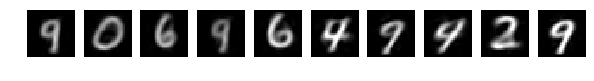

Generated Images:


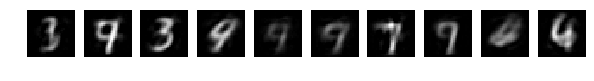

Train | Epoch: 10 [0/60000 (0%)]	Loss: 35.374847
Train | Epoch: 10 [12800/60000 (21%)]	Loss: 35.407822
Train | Epoch: 10 [25600/60000 (43%)]	Loss: 32.941734
Train | Epoch: 10 [38400/60000 (64%)]	Loss: 34.196766
Train | Epoch: 10 [51200/60000 (85%)]	Loss: 35.248962
====> Train | Epoch: 10 	 | 	 Average loss: 34.7597
====> Test  | model loss: 34.1820
Inputs:


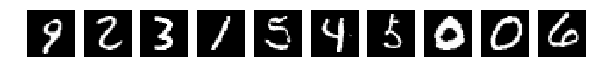

Reconstructions:


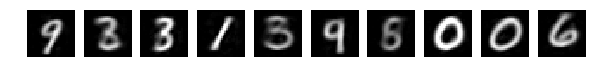

Generated Images:


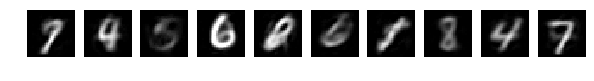

Train | Epoch: 11 [0/60000 (0%)]	Loss: 34.264473
Train | Epoch: 11 [12800/60000 (21%)]	Loss: 34.734650
Train | Epoch: 11 [25600/60000 (43%)]	Loss: 37.532928
Train | Epoch: 11 [38400/60000 (64%)]	Loss: 34.459827
Train | Epoch: 11 [51200/60000 (85%)]	Loss: 33.894119
====> Train | Epoch: 11 	 | 	 Average loss: 34.4748
====> Test  | model loss: 33.9317
Inputs:


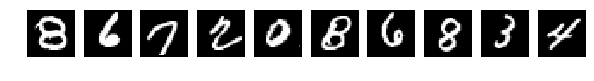

Reconstructions:


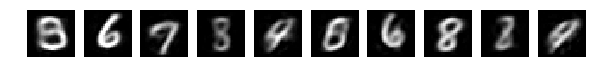

Generated Images:


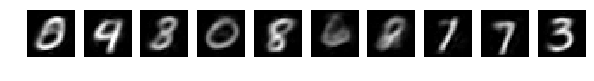

Train | Epoch: 12 [0/60000 (0%)]	Loss: 34.329250
Train | Epoch: 12 [12800/60000 (21%)]	Loss: 34.636803
Train | Epoch: 12 [25600/60000 (43%)]	Loss: 34.773422
Train | Epoch: 12 [38400/60000 (64%)]	Loss: 32.988251
Train | Epoch: 12 [51200/60000 (85%)]	Loss: 33.699947
====> Train | Epoch: 12 	 | 	 Average loss: 34.2104
====> Test  | model loss: 33.7282
Inputs:


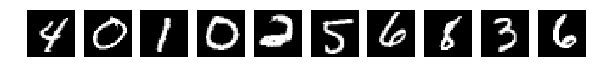

Reconstructions:


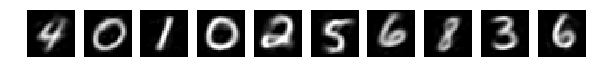

Generated Images:


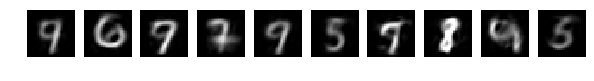

Train | Epoch: 13 [0/60000 (0%)]	Loss: 33.852802
Train | Epoch: 13 [12800/60000 (21%)]	Loss: 34.188026
Train | Epoch: 13 [25600/60000 (43%)]	Loss: 33.201706
Train | Epoch: 13 [38400/60000 (64%)]	Loss: 36.035873
Train | Epoch: 13 [51200/60000 (85%)]	Loss: 33.699051
====> Train | Epoch: 13 	 | 	 Average loss: 34.0041
====> Test  | model loss: 33.5159
Inputs:


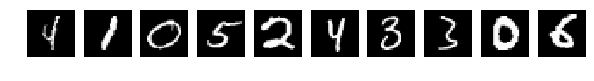

Reconstructions:


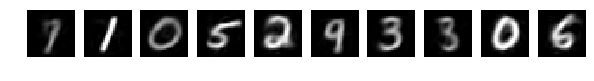

Generated Images:


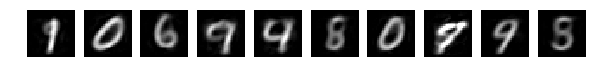

Train | Epoch: 14 [0/60000 (0%)]	Loss: 33.285683
Train | Epoch: 14 [12800/60000 (21%)]	Loss: 34.668381
Train | Epoch: 14 [25600/60000 (43%)]	Loss: 33.193504
Train | Epoch: 14 [38400/60000 (64%)]	Loss: 34.055161
Train | Epoch: 14 [51200/60000 (85%)]	Loss: 33.442558
====> Train | Epoch: 14 	 | 	 Average loss: 33.8228
====> Test  | model loss: 33.2511
Inputs:


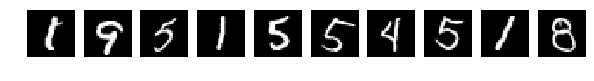

Reconstructions:


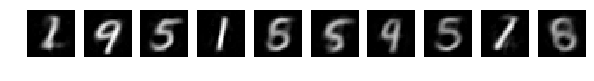

Generated Images:


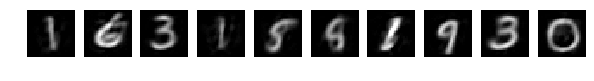

Train | Epoch: 15 [0/60000 (0%)]	Loss: 34.610851
Train | Epoch: 15 [12800/60000 (21%)]	Loss: 33.408020
Train | Epoch: 15 [25600/60000 (43%)]	Loss: 31.418344
Train | Epoch: 15 [38400/60000 (64%)]	Loss: 32.875423
Train | Epoch: 15 [51200/60000 (85%)]	Loss: 33.473022
====> Train | Epoch: 15 	 | 	 Average loss: 33.6529
====> Test  | model loss: 33.2747
Inputs:


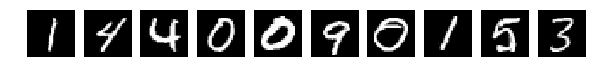

Reconstructions:


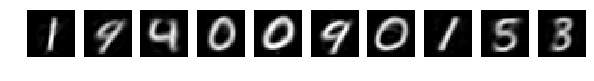

Generated Images:


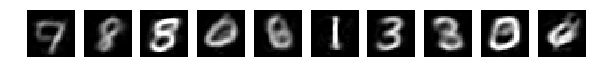

Train | Epoch: 16 [0/60000 (0%)]	Loss: 34.655182
Train | Epoch: 16 [12800/60000 (21%)]	Loss: 32.820187
Train | Epoch: 16 [25600/60000 (43%)]	Loss: 33.810345
Train | Epoch: 16 [38400/60000 (64%)]	Loss: 33.973923
Train | Epoch: 16 [51200/60000 (85%)]	Loss: 32.337101
====> Train | Epoch: 16 	 | 	 Average loss: 33.4863
====> Test  | model loss: 33.0840
Inputs:


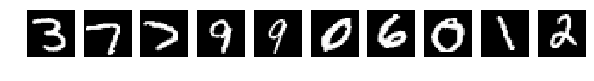

Reconstructions:


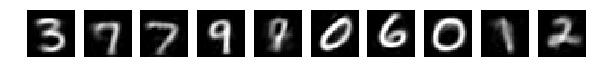

Generated Images:


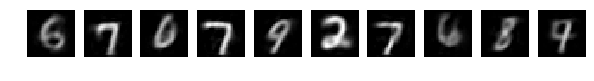

Train | Epoch: 17 [0/60000 (0%)]	Loss: 32.306648
Train | Epoch: 17 [12800/60000 (21%)]	Loss: 33.962921
Train | Epoch: 17 [25600/60000 (43%)]	Loss: 33.690979
Train | Epoch: 17 [38400/60000 (64%)]	Loss: 34.403091
Train | Epoch: 17 [51200/60000 (85%)]	Loss: 33.169125
====> Train | Epoch: 17 	 | 	 Average loss: 33.3565
====> Test  | model loss: 32.8754
Inputs:


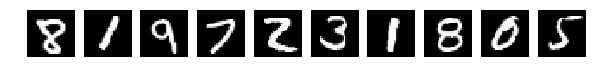

Reconstructions:


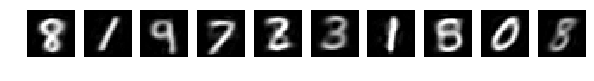

Generated Images:


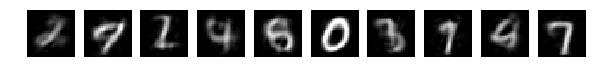

Train | Epoch: 18 [0/60000 (0%)]	Loss: 33.323532
Train | Epoch: 18 [12800/60000 (21%)]	Loss: 33.937252
Train | Epoch: 18 [25600/60000 (43%)]	Loss: 32.352699
Train | Epoch: 18 [38400/60000 (64%)]	Loss: 35.027203
Train | Epoch: 18 [51200/60000 (85%)]	Loss: 33.560673
====> Train | Epoch: 18 	 | 	 Average loss: 33.1989
====> Test  | model loss: 32.7449
Inputs:


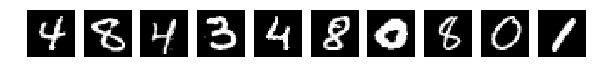

Reconstructions:


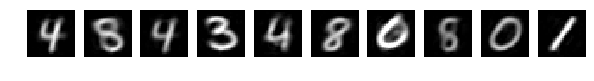

Generated Images:


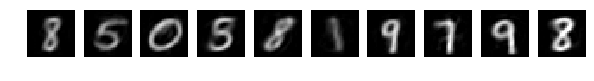

Train | Epoch: 19 [0/60000 (0%)]	Loss: 32.633392
Train | Epoch: 19 [12800/60000 (21%)]	Loss: 34.491329
Train | Epoch: 19 [25600/60000 (43%)]	Loss: 35.314289
Train | Epoch: 19 [38400/60000 (64%)]	Loss: 32.286236
Train | Epoch: 19 [51200/60000 (85%)]	Loss: 33.122612
====> Train | Epoch: 19 	 | 	 Average loss: 33.1042
====> Test  | model loss: 32.7598
Inputs:


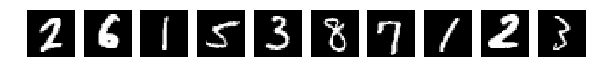

Reconstructions:


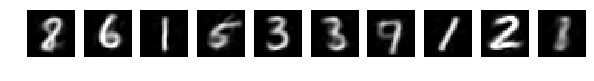

Generated Images:


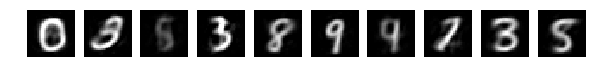

Train | Epoch: 20 [0/60000 (0%)]	Loss: 32.763351
Train | Epoch: 20 [12800/60000 (21%)]	Loss: 32.996452
Train | Epoch: 20 [25600/60000 (43%)]	Loss: 33.241875
Train | Epoch: 20 [38400/60000 (64%)]	Loss: 32.889473
Train | Epoch: 20 [51200/60000 (85%)]	Loss: 33.219986
====> Train | Epoch: 20 	 | 	 Average loss: 32.9798
====> Test  | model loss: 32.5798
Inputs:


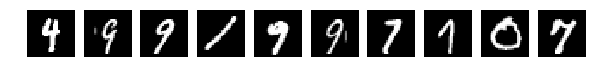

Reconstructions:


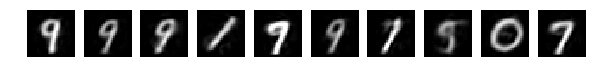

Generated Images:


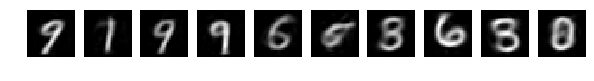

Train | Epoch: 21 [0/60000 (0%)]	Loss: 30.004827
Train | Epoch: 21 [12800/60000 (21%)]	Loss: 30.927504
Train | Epoch: 21 [25600/60000 (43%)]	Loss: 33.267128
Train | Epoch: 21 [38400/60000 (64%)]	Loss: 32.214096
Train | Epoch: 21 [51200/60000 (85%)]	Loss: 32.119537
====> Train | Epoch: 21 	 | 	 Average loss: 32.8806
====> Test  | model loss: 32.4717
Inputs:


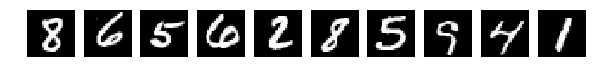

Reconstructions:


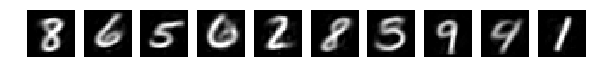

Generated Images:


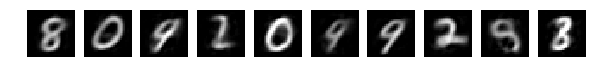

Train | Epoch: 22 [0/60000 (0%)]	Loss: 33.043381
Train | Epoch: 22 [12800/60000 (21%)]	Loss: 32.367477
Train | Epoch: 22 [25600/60000 (43%)]	Loss: 31.797909
Train | Epoch: 22 [38400/60000 (64%)]	Loss: 33.207764
Train | Epoch: 22 [51200/60000 (85%)]	Loss: 32.005684
====> Train | Epoch: 22 	 | 	 Average loss: 32.7776
====> Test  | model loss: 32.3795
Inputs:


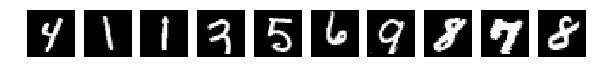

Reconstructions:


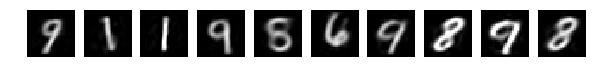

Generated Images:


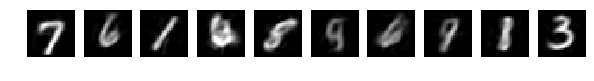

Train | Epoch: 23 [0/60000 (0%)]	Loss: 33.536995
Train | Epoch: 23 [12800/60000 (21%)]	Loss: 33.097679
Train | Epoch: 23 [25600/60000 (43%)]	Loss: 32.031715
Train | Epoch: 23 [38400/60000 (64%)]	Loss: 31.582479
Train | Epoch: 23 [51200/60000 (85%)]	Loss: 32.113758
====> Train | Epoch: 23 	 | 	 Average loss: 32.6945
====> Test  | model loss: 32.2830
Inputs:


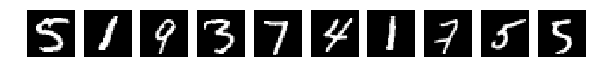

Reconstructions:


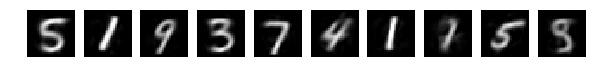

Generated Images:


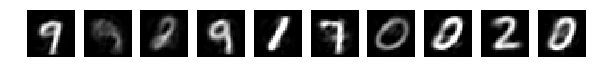

Train | Epoch: 24 [0/60000 (0%)]	Loss: 31.904943
Train | Epoch: 24 [12800/60000 (21%)]	Loss: 33.280087
Train | Epoch: 24 [25600/60000 (43%)]	Loss: 31.951729
Train | Epoch: 24 [38400/60000 (64%)]	Loss: 33.598042
Train | Epoch: 24 [51200/60000 (85%)]	Loss: 31.369194
====> Train | Epoch: 24 	 | 	 Average loss: 32.6221
====> Test  | model loss: 32.3020
Inputs:


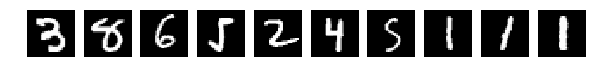

Reconstructions:


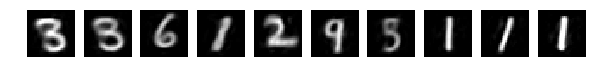

Generated Images:


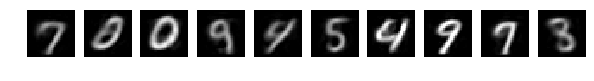

Train | Epoch: 25 [0/60000 (0%)]	Loss: 31.781637
Train | Epoch: 25 [12800/60000 (21%)]	Loss: 32.122437
Train | Epoch: 25 [25600/60000 (43%)]	Loss: 31.572096
Train | Epoch: 25 [38400/60000 (64%)]	Loss: 33.281055
Train | Epoch: 25 [51200/60000 (85%)]	Loss: 31.749813
====> Train | Epoch: 25 	 | 	 Average loss: 32.5603
====> Test  | model loss: 32.1482
Inputs:


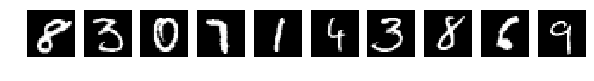

Reconstructions:


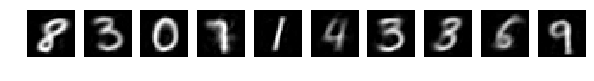

Generated Images:


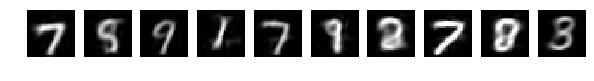

Train | Epoch: 26 [0/60000 (0%)]	Loss: 31.417248
Train | Epoch: 26 [12800/60000 (21%)]	Loss: 31.630417
Train | Epoch: 26 [25600/60000 (43%)]	Loss: 32.550888
Train | Epoch: 26 [38400/60000 (64%)]	Loss: 32.129715
Train | Epoch: 26 [51200/60000 (85%)]	Loss: 30.354237
====> Train | Epoch: 26 	 | 	 Average loss: 32.4813
====> Test  | model loss: 32.1490
Inputs:


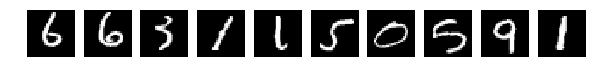

Reconstructions:


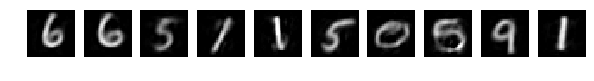

Generated Images:


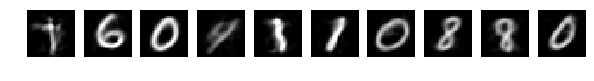

Train | Epoch: 27 [0/60000 (0%)]	Loss: 33.022652
Train | Epoch: 27 [12800/60000 (21%)]	Loss: 32.508728
Train | Epoch: 27 [25600/60000 (43%)]	Loss: 32.397736
Train | Epoch: 27 [38400/60000 (64%)]	Loss: 31.206642
Train | Epoch: 27 [51200/60000 (85%)]	Loss: 31.933289
====> Train | Epoch: 27 	 | 	 Average loss: 32.4126
====> Test  | model loss: 32.0935
Inputs:


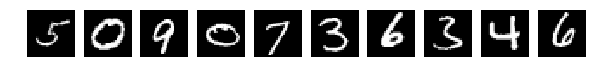

Reconstructions:


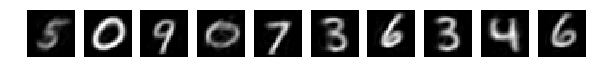

Generated Images:


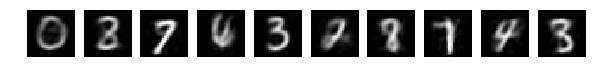

Train | Epoch: 28 [0/60000 (0%)]	Loss: 31.879826
Train | Epoch: 28 [12800/60000 (21%)]	Loss: 32.034290
Train | Epoch: 28 [25600/60000 (43%)]	Loss: 33.171036
Train | Epoch: 28 [38400/60000 (64%)]	Loss: 32.385696
Train | Epoch: 28 [51200/60000 (85%)]	Loss: 32.554016
====> Train | Epoch: 28 	 | 	 Average loss: 32.3456
====> Test  | model loss: 31.9311
Inputs:


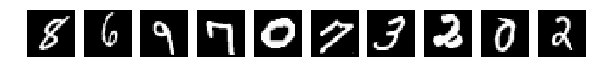

Reconstructions:


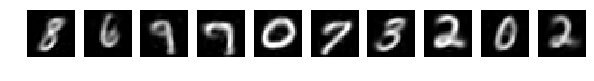

Generated Images:


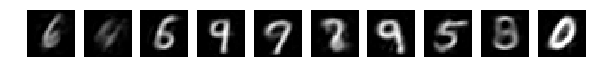

Train | Epoch: 29 [0/60000 (0%)]	Loss: 33.546242
Train | Epoch: 29 [12800/60000 (21%)]	Loss: 32.303833
Train | Epoch: 29 [25600/60000 (43%)]	Loss: 32.577065
Train | Epoch: 29 [38400/60000 (64%)]	Loss: 32.200264
Train | Epoch: 29 [51200/60000 (85%)]	Loss: 32.887691
====> Train | Epoch: 29 	 | 	 Average loss: 32.2932
====> Test  | model loss: 31.9795
Inputs:


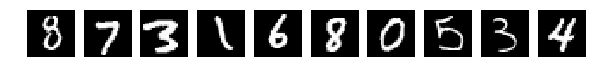

Reconstructions:


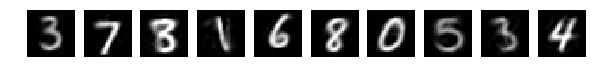

Generated Images:


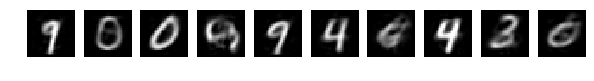

Train | Epoch: 30 [0/60000 (0%)]	Loss: 30.437771
Train | Epoch: 30 [12800/60000 (21%)]	Loss: 33.725395
Train | Epoch: 30 [25600/60000 (43%)]	Loss: 32.272991
Train | Epoch: 30 [38400/60000 (64%)]	Loss: 34.459290
Train | Epoch: 30 [51200/60000 (85%)]	Loss: 32.860554
====> Train | Epoch: 30 	 | 	 Average loss: 32.2468
====> Test  | model loss: 31.9367
Inputs:


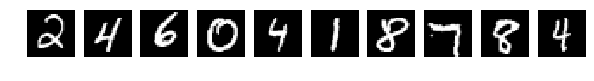

Reconstructions:


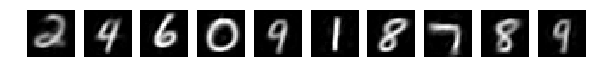

Generated Images:


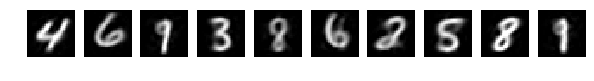

In [153]:
n_epoch = 30
run(vae, vae.parameters(), n_epoch, train_loader, test_loader,
   end_function=show_vae)

---

In [0]:
def check_interpolations(model, n_rows, n_cols):
    """
    Write a function which interpolates 10 images between two random mnist image
    """
    plt.rcParams['figure.figsize'] = (0.0 + n_cols, 0.0 + n_rows) # set default size of plots
    
    data_loader = train_loader
    
    for _ in range(n_rows):
        indices = torch.randint(data_loader.dataset.tensors[0].shape[0], (2,))
        img_1 = data_loader.dataset.tensors[0][indices][:1].flatten(start_dim=1)
        img_2 = data_loader.dataset.tensors[0][indices][1:].flatten(start_dim=1)
        
        ########################## TODO ##########################
        # Output `n_cols` images.
        # First one should be img_1. Last one should by img_2
        # Let z_1 and z_2 be latent tensors of img_1 and img_2
        # Interpolate (n_cols - 2) tensors between z_1 and z_2
        # Intermediate images must be the result of applying decoder on these (n_cols - 2) tensors
        z_1 = vae({"X": img_1.cuda()})['z']
#         print(z_1.keys())
        z_2 = vae({"X": img_2.cuda()})['z']
        delta = z_2 - z_1
        zs = [z_1 + i*delta/(n_cols-1) for i in range(n_cols)]
        output = np.array([model.decoder(zs[i]).detach().cpu().view(28, 28).numpy() for i in range(len(zs))])
        ######################## END TODO ########################
        
        show(output)


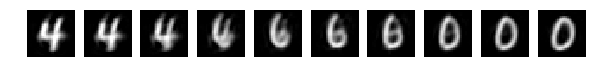

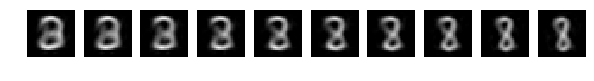

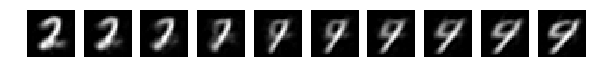

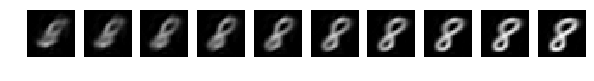

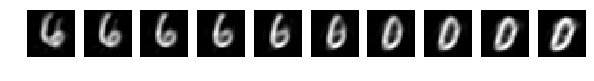

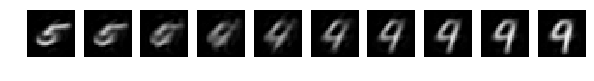

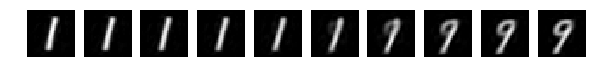

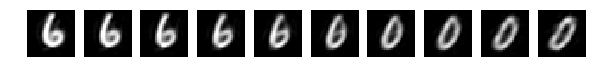

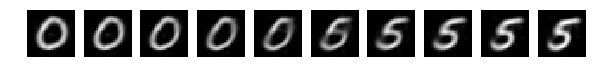

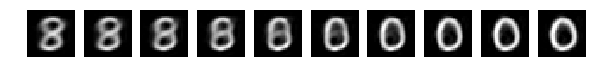

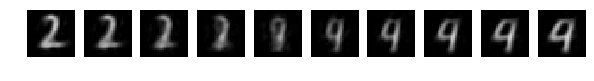

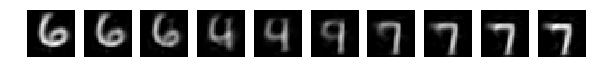

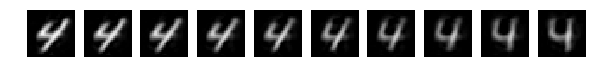

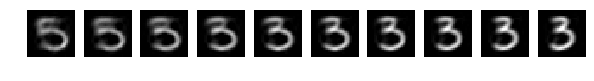

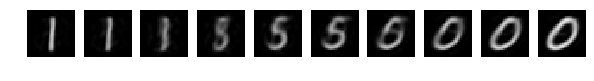

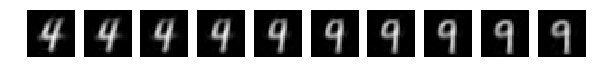

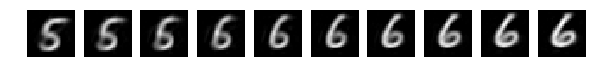

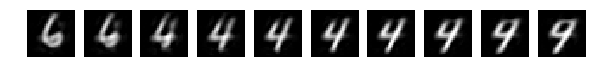

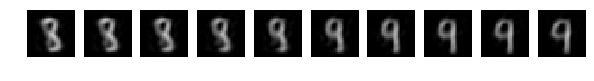

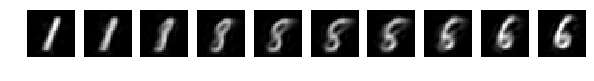

In [217]:
check_interpolations(vae, 20, 10)